# Chapter 7: Question Answering

## Building a Review-Based QA System

### The Dataset

> SubjQA is a question answering dataset that focuses on subjective (as opposed to factual) questions and answers. The dataset consists of roughly 10,000 questions over reviews from 6 different domains: books, movies, grocery, electronics, TripAdvisor (i.e. hotels), and restaurants. Each question is paired with a review and a span is highlighted as the answer to the question (with some questions having no answer). Moreover, both questions and answer spans are assigned a subjectivity label by annotators. Questions such as "How much does this product weigh?" is a factual question (i.e., low subjectivity), while "Is this easy to use?" is a subjective question (i.e., high subjectivity).
>
> In short, SubjQA provides a setting to study how well extractive QA systems perform on finding answer that are less factual and to what extent modeling subjectivity can improve the performance of QA systems.

Let's download the `subjqa` dataset and poke around a bit.

See the [Dataset card fof `subjqa` at HF](https://huggingface.co/datasets/subjqa).

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")
subjqa.shape

Found cached dataset subjqa (/home/kashiwapoodle/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': (1295, 15), 'test': (358, 15), 'validation': (255, 15)}

In [3]:
import json

#print(subjqa["train"]["answers"][1])
print(json.dumps(
    subjqa["train"][1], 
    indent=2
))

{
  "domain": "electronics",
  "nn_mod": "harsh",
  "nn_asp": "high",
  "query_mod": "not strong",
  "query_asp": "bass",
  "q_reviews_id": "7c46670208f7bf5497480fbdbb44561a",
  "question_subj_level": 1,
  "ques_subj_score": 0.5,
  "is_ques_subjective": false,
  "review_id": "ce76793f036494eabe07b33a9a67288a",
  "id": "d476830bf9282e2b9033e2bb44bbb995",
  "title": "B00001P4ZH",
  "context": "To anyone who hasn't tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they're good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer's sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they're very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I

You see how `answers` has children `text`, `answer_start`, `answer_subj_level`, etc. 

If you want to explode the children of `answers` into their own columns, then use [`datasets.flatten`](https://huggingface.co/docs/datasets/process#flatten):

In [4]:
subjqa["validation"].flatten().features.to_dict()

{'domain': {'dtype': 'string', '_type': 'Value'},
 'nn_mod': {'dtype': 'string', '_type': 'Value'},
 'nn_asp': {'dtype': 'string', '_type': 'Value'},
 'query_mod': {'dtype': 'string', '_type': 'Value'},
 'query_asp': {'dtype': 'string', '_type': 'Value'},
 'q_reviews_id': {'dtype': 'string', '_type': 'Value'},
 'question_subj_level': {'dtype': 'int64', '_type': 'Value'},
 'ques_subj_score': {'dtype': 'float32', '_type': 'Value'},
 'is_ques_subjective': {'dtype': 'bool', '_type': 'Value'},
 'review_id': {'dtype': 'string', '_type': 'Value'},
 'id': {'dtype': 'string', '_type': 'Value'},
 'title': {'dtype': 'string', '_type': 'Value'},
 'context': {'dtype': 'string', '_type': 'Value'},
 'question': {'dtype': 'string', '_type': 'Value'},
 'answers.text': {'feature': {'dtype': 'string', '_type': 'Value'},
  '_type': 'Sequence'},
 'answers.answer_start': {'feature': {'dtype': 'int32', '_type': 'Value'},
  '_type': 'Sequence'},
 'answers.answer_subj_level': {'feature': {'dtype': 'int64', '_t

In [5]:
import pandas as pd

dfs = { 
    split: dset.to_pandas() 
    for split, dset 
    in subjqa.flatten().items() 
}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Note that the `subjqa` dataset is quite small, but entirely in keeping with real-world scenarios since labelled data is very hard to find and expensive to create (you should know that!).

Now that we have transformed the `dataset` into `pandas.DataFrame`, we can use things like [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to have a closer look...

In [6]:
qa_cols = [
    "title",
    "question",
    "answers.text",
    "answers.answer_start",
    "context"
]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

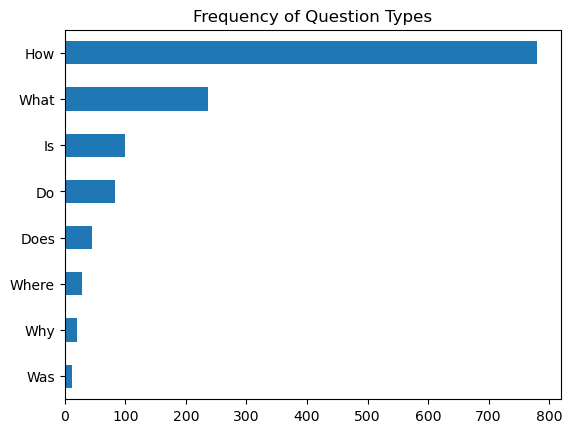

In [8]:
import matplotlib.pyplot as plt

counts = {}

question_types = [
    "What",
    "How",
    "Is",
    "Does",
    "Do",
    "Was",
    "Where",
    "Why"
]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [9]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)["question"]
    ):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Extracting Answers from Text

On SQuAD2.0:

> Extractive reading comprehension systems can often locate the correct answer to a question in a context document, but they also tend to make unreliable guesses on questions for which the correct answer is not stated in the context. Existing datasets either focus exclusively on answerable questions, or use automatically generated unanswerable questions that are easy to identify. To address these weaknesses, we present SQuAD 2.0, the latest version of the Stanford Question Answering Dataset (SQuAD). SQuAD 2.0 combines existing SQuAD data with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD 2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering. SQuAD 2.0 is a challenging natural language understanding task for existing models: a strong neural system that gets 86% F1 on SQuAD 1.1 achieves only 66% F1 on SQuAD 2.0. 

Suggested reading:
* [SQuAD2.0 - The Stanford Question Answering Dataset](https://rajpurkar.github.io/SQuAD-explorer/)
* [Know What You Don't Know: Unanswerable Questions for SQuAD]() by Rajpurkar, Jia, and Liang, 2018
* [Question Answering on SQuAD2.0](https://paperswithcode.com/sota/question-answering-on-squad20) on paperswithcode.com

### Tokening text for QA

* Training dataset is small, with only 1295 examples.
* Since the structure of the labels for QA (predicting the start/end of an answer span) should be the same across datasets, starting from a fine-tuned, large-scale QA model is the sane approach.

We will use [`deepset/minilm-uncased-squad2`](https://huggingface.co/deepset/minilm-uncased-squad2#minilm-l12-h384-uncased-for-qa).

In [10]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MG/minute, so about 6000 hours depending on file size."""

inputs = tokenizer(
    question,
    context,
    return_tensors="pt"
)

`inputs` has `input_ids` and `attention_mask` as expected, but notice how `token_type_id` indicate `0` for question token and `1` for context token.

In [12]:
pd.DataFrame(
    dict(
        (k, v.tolist()[0]) 
        for k,v in inputs.items()
    )
).T

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [13]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mg / minute, so about 6000 hours depending on file size. [SEP]


In [14]:
import torch

from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-1.1286, -4.7415, -5.3876, -5.2379, -5.2723, -5.5013, -4.9711, -6.1821,
         -1.1286, -0.0502, -0.3999, -1.9431,  3.2140,  4.1175, -1.1694, -3.8895,
         -2.1539, -4.5801, -1.3942,  4.1694,  5.3227, -0.0295, -3.0786, -4.8637,
         -2.3779, -3.5348, -3.5455, -1.1286]]), end_logits=tensor([[-1.0579, -5.4757, -5.0125, -5.1458, -5.4216, -5.4915, -5.1583, -4.5826,
         -1.0580, -3.8277, -1.1060, -3.8418, -3.2789, -1.2299, -0.9271, -3.3560,
          4.1270,  0.2892, -3.2542, -3.1378,  1.0524,  5.8469, -0.2193, -4.8842,
         -3.3028, -0.1381,  1.6563, -1.0579]]), hidden_states=None, attentions=None)


In [15]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [16]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [17]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1

answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


... and the same as above, but now wrapped in an HF `pipeline`...

In [18]:
from transformers import pipeline

pipe = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer
)

pipe(
    question=question, 
    context=context, 
    topk=5
)

/opt/conda/envs/transformers-py38/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:323: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.46839281916618347,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.14781419932842255,
  'start': 32,
  'end': 48,
  'answer': 'about 6000 hours'},
 {'score': 0.14034153521060944,
  'start': 16,
  'end': 48,
  'answer': '1 MG/minute, so about 6000 hours'},
 {'score': 0.05686337128281593,
  'start': 10,
  'end': 48,
  'answer': 'about 1 MG/minute, so about 6000 hours'},
 {'score': 0.02513236179947853,
  'start': 16,
  'end': 27,
  'answer': '1 MG/minute'}]

In the case of a question for which no answer is possble, this model will assign a high start and end score to the `[CLS]` token, mapping the output to the empty string.

In [19]:
pipe(
    question="How many roads must a man walk?",
    context=context,
    handle_impossible_answer=True
)

{'score': 0.9904054999351501, 'start': 0, 'end': 0, 'answer': ''}

### Dealing with long passages

In [20]:
example = dfs["train"].iloc[0][["question", "context"]]

tokenized_example = tokenizer(
    example["question"],
    example["context"],
    return_overflowing_tokens=True,
    max_length=100,
    stride=25
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [22]:
for window in tokenized_example["input_ids"]:
    print(f"{window}")

[101, 2129, 2003, 1996, 3321, 1029, 102, 1045, 2031, 2018, 12849, 4757, 2132, 19093, 1999, 1996, 2627, 1010, 4013, 26424, 2050, 1998, 1053, 2480, 1011, 5585, 1012, 1996, 12849, 4757, 3417, 9331, 3217, 2003, 12109, 1998, 2038, 2307, 3321, 3433, 1012, 1996, 2147, 2307, 2007, 2026, 11924, 3042, 1998, 2064, 2022, 1000, 4565, 2039, 1000, 2000, 2022, 3344, 1999, 2026, 9055, 6598, 2030, 3274, 4524, 2302, 2893, 24514, 2098, 1012, 2027, 2024, 2200, 2422, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 102]
[101, 2129, 2003, 1996, 3321, 1029, 102, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 2305, 1998, 2154, 2488, 2084, 2151, 4540, 1011, 13007, 2071, 2022, 1998, 2024, 2471, 2004, 2204, 2004, 1996, 4013, 26424, 2050, 1012, 2027, 2024, 1000, 2330, 2250, 1000, 2132, 19093, 2061, 2017, 3685, 267

To clarify, here is are the first 75 tokens of the 100 tokens that make up the first window; along with the trailing 25 tokens that make up the stride (overlap). Tokens have been decoded.

In [23]:
print(f"Tokens 0 through 74 for window 0\n=====\n{tokenizer.decode(tokenized_example['input_ids'][0][7:-26])}")
print()
print(f"... and the last 25 tokens for window 0 making up the stride:\n=====\n{tokenizer.decode(tokenized_example['input_ids'][0][-26:])}")

Tokens 0 through 74 for window 0
=====
i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light

... and the last 25 tokens for window 0 making up the stride:
=====
and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]


And here is what window 1 looks like:

In [24]:
print(f"Tokens 0 through 25 for the stride (overlapping) input continuation in window 1\n=====\n{tokenizer.decode(tokenized_example['input_ids'][1][7:7+25])}")
print()
print(f"... and the trailing remaining tokens for window 1\n=====\n{tokenizer.decode(tokenized_example['input_ids'][1][7+25:])}")

Tokens 0 through 25 for the stride (overlapping) input continuation in window 1
=====
and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is

... and the trailing remaining tokens for window 1
=====
night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]


----

### Using Haystack to Build a QA Pipeline

_WARNING!!! Apparently the farm-haystack API has change since the writing of this book!_

While referring to the Basic Install procedures per [Quick Start on haystack.deepset.ai](https://haystack.deepset.ai/overview/quick-start) and [Tutorial: Build Your First Question Answering System](https://haystack.deepset.ai/tutorials/01_basic_qa_pipeline) on the Haystack by deepset website, we will make appropriate changes.

#### Installing `farm-haystack`

This part will require the installation of `farm-haystack` (NOT to be confused with `haystack`!).

    pip install farm-haystack
    
    pip install 'farm-haystack[elasticsearch]' 

In [25]:
import os
from pathlib import Path
from subprocess import Popen, PIPE, STDOUT

#### Installing ElasticSearch

* The following code block downloads and install `elasticsearch`.
* This bit needs to be done only _once_!

#### Start `elasticsearch` server

Execute the following code block to start up `elasticsearch`.

In [26]:
# this will start up elasticsearch and create a PID file...
es_server = Popen(
    args=["elasticsearch-7.9.2/bin/elasticsearch", "-p", "pidfile"],
    stdout=PIPE,
    stderr=STDOUT
)

# wait until Elasticsearch has started..
!sleep 30

#### `curl` call to check `elasticsearch` server status

This `curl` call can be used to check if `elasticsearch` is running or not...

In [27]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "t4-us-central1-f",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "dwBITPl8QwS5wtWeKRNKow",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


#### Stop `elasticsearch` server

Execute the following code block to stop `elasticsearch`.

----

### Instatiate a document store

In [28]:
from haystack.document_stores import ElasticsearchDocumentStore

# return the document embedding for later use with dense retriever
#                                                  ^^^^^
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [29]:
for split, df in dfs.items():
    # exclude duplicate reviews
    docs = [{
        "content": row["context"],
        "meta": {
            "item_id": row["title"],
            "question_id": row["id"],
            "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")    

Loaded 1615 documents


### Initializing a retriever

In [30]:
from haystack.nodes import BM25Retriever

retriever = BM25Retriever(document_store=document_store)

In [31]:
item_id = "B0074BW614"
query = "Is it good for reading?"

retrieved_docs = retriever.retrieve(
    query=query,
    top_k=3,
    filters={
        "item_id": item_id,
        "split": ["train"]
    },
)

In [32]:
print(retrieved_docs[0])
print()
print(type(retrieved_docs[0]))

<Document: id=252e83e25d52df7311d597dc89eef9f6, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never ...'>

<class 'haystack.schema.Document'>


In [33]:
doc = retrieved_docs[0]
print(doc.to_dict())

{'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}


#### Initializing a reader

> A Reader scans the texts it received from the Retriever and extracts the top answer candidates. Readers are based on powerful deep learning models but are much slower than Retrievers at processing the same amount of text.
> <br/>... from [Tutorial: Build Your First Question Answering System](https://haystack.deepset.ai/tutorials/01_basic_qa_pipeline)
> <br/><br/>MiniLM
> <br/>A distilled model that sacrifices a little accuracy for speed.
> <br/>Pro: 40% smaller, 50% faster inference speed, and better accuracy than BERT base.
> <br/>Con: Still doesn’t match the best base-sized models in accuracy.
> <br/>... from [Models, Haystack documentation](https://docs.haystack.deepset.ai/docs/reader#models)


In [34]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_len, doc_stride = 384, 128

reader = FARMReader(
    model_name_or_path="deepset/roberta-base-squad2", 
    progress_bar=False,
    max_seq_len=max_seq_len,
    doc_stride=doc_stride,
    return_no_answer=True
)

In [35]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 3.9765353202819824, 'answers': [<Answer {'answer': '', 'type': 'extractive', 'score': 0.570759527304695, 'context': None, 'offsets_in_document': [{'start': 0, 'end': 0}], 'offsets_in_context': [{'start': 0, 'end': 0}], 'document_ids': None, 'meta': {}}>]}


#### Putting it all together

The API for `ExtractiveQAPipeline` appears to have changed drastically:

* `top_k_retrievers` is gone as direct parameter; use `params` and `Retriever` node name
* `top_k_readers` is gone as direct parameter; use `params` and `Reader` node name
* `filters` s gone as direct parameter; [use `params` and `filters` to filter results by using `meta` fields](https://docs.haystack.deepset.ai/docs/metadata-filtering#basic-filters)

In [36]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, retriever)

In [37]:
n_answers = 3

preds = pipe.run(
    query=query,
    params={
        "filters": {
            "item_id": item_id,
            "split": ["train"]
        },
        "Retriever": {"top_k": 3},
    },
)

answers = [ans for ans in preds['answers'] ]

In [39]:
print(f"Question: {preds['query']}\n")

for i,answer in enumerate(answers):
    print(f"Answer {i+1}: {answer.answer}")
    print(f"Review snippet: ...{answer.context}\n")

Question: Is it good for reading?

Answer 1: 
Review snippet: ...None

Answer 2: it is great for reading books
Review snippet: ...myself after becoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest goo

Answer 3: It's light enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading
Review snippet: ...t perfect for me. It's light enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the colo

Answer 4: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la

Answer 5: the larger screen compared to the Kindle makes for easier reading
Review snippet: ...ght enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I 

### Evaluating the Retriever

In [41]:
from haystack.pipeline import Pipeline

ModuleNotFoundError: No module named 'haystack.pipeline'

In [42]:
from haystack.eval import EvalDocuments

ModuleNotFoundError: No module named 'haystack.eval'